In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from replay_memory import ReplayBuffer, PrioritizedReplayBuffer

from networks import DQNBase, CosineEmbeddingNetwork,\
    FractionProposalNetwork, QuantileNetwork,tbQuantileNetwork, NoisyLinear


import random
import os
import pickle
import time
from collections import deque
import matplotlib.pyplot as plt
from wrappers import wrap, wrap_cover, SubprocVecEnv

In [2]:
STATE_LEN = 4
# target policy sync interval
TARGET_REPLACE_ITER = 1
# simulator steps for start learning
LEARN_START = int(1e+3)
# (prioritized) experience replay memory size
MEMORY_CAPACITY = int(1e+5)
# simulator steps for learning interval
LEARN_FREQ = 4
# quantile numbers for QR-DQN
N_QUANT = 100
# quantiles
QUANTS = np.linspace(0.0, 1.0, N_QUANT + 1)[1:]
QUANTS_TARGET = (np.linspace(0.0, 1.0, N_QUANT + 1)[:-1] + QUANTS)/2


env_name='Breakout'
'''Environment Settings'''
# number of environments for C51
N_ENVS = 16
# openai gym env name
ENV_NAME = '{}NoFrameskip-v4'.format(env_name)
SEED = 0
env = SubprocVecEnv([wrap_cover(ENV_NAME,SEED) for i in range(N_ENVS)])
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape
# Total simulation step
STEP_NUM = int(6e+6)
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 32
# learning rage
LR = 5e-5
# epsilon-greedy
EPSILON = 1.0

/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/hom

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
USE GPU: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.

In [3]:
N_ACTIONS

4

In [3]:
def evaluate_quantile_at_action(s_quantiles, actions):
    assert s_quantiles.shape[0] == actions.shape[0]

    batch_size = s_quantiles.shape[0]
    N = s_quantiles.shape[1]

    # Expand actions into (batch_size, N, 1).
    action_index = actions[..., None].expand(batch_size, N, 1)

    # Calculate quantile values at specified actions.
    sa_quantiles = s_quantiles.gather(dim=2, index=action_index)
    return sa_quantiles

def calculate_huber_loss(td_errors, kappa=1.0):
    return torch.where(
        td_errors.abs() <= kappa,
        0.5 * td_errors.pow(2),
        kappa * (td_errors.abs() - 0.5 * kappa))


def calculate_quantile_huber_loss(td_errors, taus, kappa=1.0):
    assert not taus.requires_grad
    batch_size, N, N_dash = td_errors.shape

    # Calculate huber loss element-wisely.
    element_wise_huber_loss = calculate_huber_loss(td_errors, kappa)
    assert element_wise_huber_loss.shape == (
        batch_size, N, N_dash)

    # Calculate quantile huber loss element-wisely.
    element_wise_quantile_huber_loss = torch.abs(
        taus[..., None] - (td_errors.detach() < 0).float()
        ) * element_wise_huber_loss / kappa
    assert element_wise_quantile_huber_loss.shape == (
        batch_size, N, N_dash)

    return element_wise_quantile_huber_loss.sum(dim=1).mean()

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # nn.Sequential
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # action value distribution
        self.fc_q = nn.Linear(512, N_ACTIONS * N_QUANT) 
            
        self.weight_net = nn.Sequential(
                nn.Linear(7 * 7 * 64, 512),
                nn.ReLU(),
                nn.Linear(512, 2*N_ACTIONS),
            )
        self.relu = nn.ReLU()
        
        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x.size(0) : minibatch size
        mb_size = x.size(0)
        # x: (m, 84, 84, 4) tensor
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        state_embeddings = x.view(x.size(0), -1)       
        x = F.relu(self.fc(state_embeddings))
        quantiles = self.fc_q(x).view(mb_size, N_QUANT, N_ACTIONS)

        weight = self.weight_net(state_embeddings).view(mb_size, 2, N_ACTIONS)
        w = weight[:,0,:].unsqueeze(dim=1).expand(quantiles.shape)
        w = self.relu(w)
        b = weight[:,1,:].unsqueeze(dim=1).expand(quantiles.shape)
        log_probs = F.log_softmax(quantiles, dim=1)
        probs = torch.cumsum(log_probs.exp(),dim=1)
        nc_quantiles = w*probs+b 
  
               
        return nc_quantiles.transpose(1,2)

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

class TBQRDQN(object):
    def __init__(self):
        self.pred_net, self.target_net = ConvNet(), ConvNet()
        # sync eval target
        self.update_target(self.target_net, self.pred_net, 1.0)
        # use gpu
        if USE_GPU:
            self.pred_net.cuda()
            self.target_net.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        # target network step counter
        self.learn_step_counter = 0
        
        # ceate the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.pred_net.parameters(), lr=LR)
        
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
            
    def save_model(self):
        # save prediction network and target network
        self.pred_net.save(PRED_PATH)
#         self.target_net.save(TARGET_PATH)

    def load_model(self,pred_path):
        # load prediction network and target network
        self.pred_net.load(pred_path)
#         self.target_net.load(TARGET_PATH)

    def choose_action(self, x, EPSILON):
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()

        if np.random.uniform() >= EPSILON:
            # greedy case
            action_value = self.pred_net(x).mean(dim=2) # (N_ENVS, N_ACTIONS)
            action = torch.argmax(action_value, dim=1).data.cpu().numpy()
        else:
            # random exploration case
            action = np.random.randint(0, N_ACTIONS, (x.size(0)))
        return action

    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))

    def learn(self):
        self.learn_step_counter += 1
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.update_target(self.target_net, self.pred_net, 1e-2)
    
        b_s, b_a, b_r,b_s_, b_d = self.replay_buffer.sample(BATCH_SIZE)
        b_w, b_idxes = np.ones_like(b_r), None
            
        b_s = torch.FloatTensor(b_s)
        b_a = torch.LongTensor(b_a)
        b_r = torch.FloatTensor(b_r)
        b_s_ = torch.FloatTensor(b_s_)
        b_d = torch.FloatTensor(b_d)

        if USE_GPU:
            b_s, b_a, b_r, b_s_, b_d = b_s.cuda(), b_a.cuda(), b_r.cuda(), b_s_.cuda(), b_d.cuda()

        # action value distribution prediction
        q_eval = self.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
#         x = q_eval.cpu().detach().numpy()
        mb_size = q_eval.size(0)
        q_eval = torch.stack([q_eval[i].index_select(0, b_a[i]) for i in range(mb_size)]).squeeze(1) 
        # (m, N_QUANT)
        q_eval = q_eval.unsqueeze(2) # (m, N_QUANT, 1)
        # note that dim 1 is for present quantile, dim 2 is for next quantile
        
        # get next state value
        q_next = self.target_net(b_s_).detach() # (m, N_ACTIONS, N_QUANT)
        best_actions = q_next.mean(dim=2).argmax(dim=1) # (m)
        q_next = torch.stack([q_next[i].index_select(0, best_actions[i]) for i in range(mb_size)]).squeeze(1)
        # (m, N_QUANT)
        q_target = b_r.unsqueeze(1) + GAMMA * (1. -b_d.unsqueeze(1)) * q_next 
        # (m, N_QUANT)
        q_target = q_target.unsqueeze(1) # (m , 1, N_QUANT)

        # quantile Huber loss
        u = q_target.detach() - q_eval # (m, N_QUANT, N_QUANT)
        tau = torch.FloatTensor(QUANTS_TARGET).view(1, -1, 1) # (1, N_QUANT, 1)
        # note that tau is for present quantile
        if USE_GPU:
            tau = tau.cuda()
        weight = torch.abs(tau - u.le(0.).float()) # (m, N_QUANT, N_QUANT)
        loss = F.smooth_l1_loss(q_eval, q_target.detach(), reduction='none')
        # (m, N_QUANT, N_QUANT)
        loss = torch.mean(weight * loss, dim=1).mean(dim=1)
        # print('1',loss.numpy())
        
        # calc importance weighted loss
        b_w = torch.Tensor(b_w)
        
        if USE_GPU:
            b_w = b_w.cuda()
        # loos = b_w * loss
        # print('2',(b_w * loss).numpy())
        loss = torch.mean(b_w * loss)
        
        # backprop loss
        self.optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.pred_net.parameters(),0.1)
        self.optimizer.step()
#         return x

class QRDQN(nn.Module):
    def __init__(self):
        super(QRDQN, self).__init__()
        # nn.Sequential
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # action value distribution
        self.fc_q = nn.Linear(512, N_ACTIONS * N_QUANT) 
            
        torch.manual_seed(SEED)
        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x.size(0) : minibatch size
        mb_size = x.size(0)
        # x: (m, 84, 84, 4) tensor
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        
        # note that output of QR-DQN is quantile values of value distribution
        action_value = self.fc_q(x).view(mb_size, N_ACTIONS, N_QUANT)

        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        

        

class TBIQN(nn.Module):
    def __init__(self):
        super(TBIQN, self).__init__()

        self.feature_extraction = nn.Sequential(
        	# Conv2d(输入channels, 输出channels, kernel_size, stride)
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.phi = nn.Linear(1, 7 * 7 * 64, bias=False)
        self.phi_bias = nn.Parameter(torch.zeros(7 * 7 * 64))
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # action value distribution
        self.fc_q = nn.Linear(512, N_ACTIONS) 
        self.weight_net = nn.Sequential(
                nn.Linear(7 * 7 * 64, 512),
                nn.ReLU(),
                nn.Linear(512, 2*N_ACTIONS),
            )
        self.relu = nn.ReLU()
               
        # Initialization 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            
    def forward(self, x, n):
        # x.size(0) : minibatch size
        mb_size = x.size(0)
        x = self.feature_extraction(x / 255.0) # (m, 7 * 7 * 64)
        state_embeddings = x.view(x.size(0), -1) 
        # Rand Initlialization
        tau = torch.sort(torch.rand(n, 1),dim=0)[0] # (N_QUANT, 1)
        # Quants=[1,2,3,...,N_QUANT]
        quants = torch.arange(0, 64, 1.0) # (N_QUANT,) paper says quans should vary from 0 to 64
        if USE_GPU:
            tau = tau.cuda()
            quants = quants.cuda()
        # phi_j(tau) = RELU(sum(cos(π*i*τ)*w_ij + b_j))
        cos_trans = torch.cos(quants * tau * 3.141592).unsqueeze(2) # (N_QUANT, N_QUANT, 1)
        rand_feat = F.relu(self.phi(cos_trans).mean(dim=1) + self.phi_bias.unsqueeze(0)).unsqueeze(0) 
        # (1, N_QUANT, 7 * 7 * 64)
        x = x.view(x.size(0), -1).unsqueeze(1)  # (m, 1, 7 * 7 * 64)
        # Zτ(x,a) ≈ f(ψ(x) @ φ(τ))a  @表示按元素相乘
        x = x * rand_feat                       # (m, N_QUANT, 7 * 7 * 64)
        x = F.relu(self.fc(x))                  # (m, N_QUANT, 512)
        
        # note that output of IQN is quantile values of value distribution
        quantiles = self.fc_q(x) # (m, N_QUANT, N_ACTIONS)
        
        weight = self.weight_net(state_embeddings).view(mb_size, 2, N_ACTIONS)
        w = weight[:,0,:].unsqueeze(dim=1).expand(quantiles.shape)
        w = self.relu(w)
        b = weight[:,1,:].unsqueeze(dim=1).expand(quantiles.shape)
        log_probs = F.log_softmax(quantiles, dim=1)
        probs = torch.cumsum(log_probs.exp(),dim=1)
        nc_quantiles = w*probs+b 
        return nc_quantiles.transpose(1, 2), tau


    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

class IQN(nn.Module):
    def __init__(self):
        super(IQN, self).__init__()

        self.feature_extraction = nn.Sequential(
        	# Conv2d(输入channels, 输出channels, kernel_size, stride)
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.phi = nn.Linear(1, 7 * 7 * 64, bias=False)
        self.phi_bias = nn.Parameter(torch.zeros(7 * 7 * 64))
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # action value distribution
        self.fc_q = nn.Linear(512, N_ACTIONS) 
        
        # Initialization 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            
    def forward(self, x,n):
        # x.size(0) : minibatch size
        mb_size = x.size(0)
        x = self.feature_extraction(x / 255.0) # (m, 7 * 7 * 64)
        # Rand Initlialization
        tau = torch.rand(n, 1) # (N_QUANT, 1)
        # Quants=[1,2,3,...,N_QUANT]
        quants = torch.arange(0, 64, 1.0) # (N_QUANT,1)
        if USE_GPU:
            tau = tau.cuda()
            quants = quants.cuda()
        # phi_j(tau) = RELU(sum(cos(π*i*τ)*w_ij + b_j))
        cos_trans = torch.cos(quants * tau * 3.141592).unsqueeze(2) # (N_QUANT, N_QUANT, 1)
        rand_feat = F.relu(self.phi(cos_trans).mean(dim=1) + self.phi_bias.unsqueeze(0)).unsqueeze(0) 
        # (1, N_QUANT, 7 * 7 * 64)
        x = x.view(x.size(0), -1).unsqueeze(1)  # (m, 1, 7 * 7 * 64)
        # Zτ(x,a) ≈ f(ψ(x) @ φ(τ))a  @表示按元素相乘
        x = x * rand_feat                       # (m, N_QUANT, 7 * 7 * 64)
        x = F.relu(self.fc(x))                  # (m, N_QUANT, 512)
        
        # note that output of IQN is quantile values of value distribution
        action_value = self.fc_q(x).transpose(1, 2) # (m, N_ACTIONS, N_QUANT)

        return action_value, tau


    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

In [4]:
itera = 5
tbqrdqn = TBQRDQN()

tbqrdqn.load_model('data/qcmodel/tbqrdqns0_2net100up1_iter40_Breakout.pkl')

# tbqrdqn.load_model('data/qcmodel/extbqrdqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))

# # fqff = FQF()
# # fqff.load_model('data/qcmodel/fqfregp5_pred_net32_up10_{}.pkl'.format(env_name))

# # tbfqf = TBFQF()
# # tbfqf.load('data/qcmodel/tbfqfregp5_pred_net32_up10_{}.pkl'.format(env_name))
tbiqn = TBIQN().cuda()
# tbiqn.load('data/qcmodel/tbiqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))

# iqn.load('data/qcmodel/iqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))


In [5]:
EPSILON = 0.1
s = np.array(env.reset())
for step in range(5000):
    a = tbqrdqn.choose_action(s, EPSILON)

    # take action and get next state
    s_, r, done, infos = env.step(a)
    # log arrange

    s_ = np.array(s_)

    # clip rewards for numerical stability
    clip_r = np.sign(r)

    # store the transition
    for i in range(N_ENVS):
        tbqrdqn.store_transition(s[i], a[i], clip_r[i], s_[i], done[i])
    s = s_

In [6]:
import cv2
#2右3左
for i in range(5000):    
    s,a,r,s_,d = tbqrdqn.replay_buffer._storage[1+i*16]
    cv2.imwrite('../figure_breakout/step{}_r{}a{}.jpg'.format(i,r,a),s[0].transpose())
 

([], <a list of 0 Text yticklabel objects>)

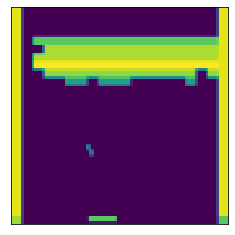

In [10]:

b_s, b_a, b_r,b_s_, b_d = tbqrdqn.replay_buffer._storage[1+707*16]
# b_s, b_a, b_r,b_s_, b_d = self.replay_buffer.sample(BATCH_SIZE)
b_s = torch.FloatTensor(b_s).unsqueeze(0)
b_a = torch.LongTensor(b_a).unsqueeze(0)
# b_r = torch.FloatTensor(b_r).unsqueeze(0)
b_s_ = torch.FloatTensor(b_s_).unsqueeze(0)
# b_d = torch.FloatTensor(b_d).unsqueeze(0)
image = b_s.detach().cpu().numpy()
fig,ax = plt.subplots()
plt.figure(1)
plt.imshow(image[0][0].transpose())
plt.xticks([])
plt.yticks([])
# fig.savefig('../quantile_curve/state.eps',dpi=600,format='eps')

torch.Size([100])
exploration_action:right_jump
exploit_action:right_jump


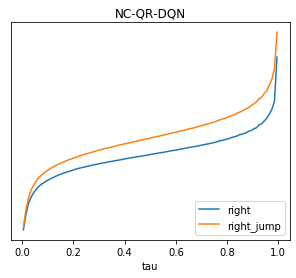

In [339]:
itera = 5
b_s,b_a = b_s.cuda(),b_a.cuda()
tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter5_Breakout.pkl')
# action_list = ['stop','jump','up','down','right','left','right_jump']
tbq_eval5 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
print(tbq_eval5[0,7,:].shape)
qq = tbq_eval5.cpu().detach().numpy()
tbq_eval5 = tbq_eval5.index_select(1,torch.LongTensor([0,1,2,5,6,7,11]).cuda())
median = torch.median(tbq_eval5, dim=-1).values.unsqueeze(-1).expand(tbq_eval5.shape)

q = tbq_eval5.mean(dim=2)
bonus_c = 50 * np.sqrt(np.log(tbqrdqn.memory_counter) / tbqrdqn.memory_counter)
var_plus = torch.sqrt(torch.sum(torch.pow((torch.where(tbq_eval5 - median > 0, tbq_eval5, median) - median), 2), dim=-1)/(2*100))
action_value = q + bonus_c * var_plus
best_actions = action_value.argmax(dim=1).detach().cpu().numpy()[0]
print('exploration_action:{}'.format(action_list[best_actions]))

action = int(torch.argmax(q, dim=1).detach().cpu().numpy())
print('exploit_action:{}'.format(action_list[action]))



#0-不动，1跳,2上，3右走，4左走，5下，6右走，7左走，8右走，9左走，10跳（上绳子），11右跳
#12左走，13下，14右走，15左走，16右走

import matplotlib.pyplot as plt
# plt.plot(QUANTS_TARGET,qq[0][0,:],label='stop')#停
# plt.plot(QUANTS_TARGET,qq[0][1,:],label='jump')#跳
# plt.plot(QUANTS_TARGET,qq[0][2,:],label='up')#上
# plt.plot(QUANTS_TARGET,qq[0][3,:],label='action-4')
# plt.plot(QUANTS_TARGET,qq[0][4,:],label='action-5')
# plt.plot(QUANTS_TARGET,qq[0][5,:],label='down')#下
plt.plot(QUANTS_TARGET,qq[0][6,:],label='right')#右
# plt.plot(QUANTS_TARGET,qq[0][7,:],label='left')#左
# plt.plot(QUANTS_TARGET,qq[0][8,:],label='action-9')
# plt.plot(QUANTS_TARGET,qq[0][9,:],label='action-10')
# plt.plot(QUANTS_TARGET,qq[0][10,:],label='action-11')
plt.plot(QUANTS_TARGET,qq[0][11,:],label='right_jump')#右跳
# plt.plot(QUANTS_TARGET,qq[0][12,:],label='action-13')
# plt.plot(QUANTS_TARGET,qq[0][13,:],label='action-14')
# plt.plot(QUANTS_TARGET,qq[0][14,:],label='action-15')
# plt.plot(QUANTS_TARGET,qq[0][15,:],label='action-16')
# plt.plot(QUANTS_TARGET,qq[0][16,:],label='action-17')
# plt.plot(QUANTS_TARGET,qq[0][17,:],label='action-18')

plt.title('NC-QR-DQN'.format(env_name))
plt.xlabel('tau')
# plt.ylabel('Value')
plt.yticks([])
plt.legend(loc=4)
plt.show()
#0-不动，1跳,2上，3右走，4左走，5下，6右走，7左走，8右走，9左走，10跳（上绳子），11右跳
#12左走，13下，14右走，15左走，16右走

torch.Size([100])
[1.0033721 1.0215689] [0.00764484 0.00950942]


Text(0.5, 1.0, 'Q-value v.s bonus without crossing')

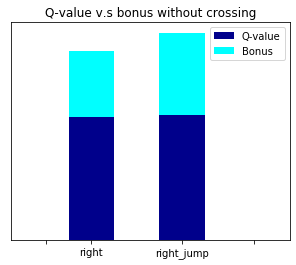

In [334]:
b_s,b_a = b_s.cuda(),b_a.cuda()
tbqrdqn.load_model('data/model/extbqrdqn_100_net_MontezumaRevenge.pkl')
action_list = ['stop','jump','up','down','right','left','right_jump']
tbq_eval5 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
print(tbq_eval5[0,7,:].shape)
qq = tbq_eval5.cpu().detach().numpy()
# tbq_eval5 = tbq_eval5.index_select(1,torch.LongTensor([0,1,2,5,6,7,11]).cuda())
# q_val = tbq_eval5.index_select(1,torch.LongTensor([2,11]).cuda())
median = torch.median(tbq_eval5, dim=-1).values.unsqueeze(-1).expand(tbq_eval5.shape)

q = tbq_eval5.mean(dim=2)
bonus_c = 50 * np.sqrt(np.log(tbqrdqn.memory_counter) / tbqrdqn.memory_counter)
var_plus = torch.sqrt(torch.sum(torch.pow((torch.where(tbq_eval5 - median > 0, tbq_eval5, median) - median), 2), dim=-1)/(2*100))
action_value = q + bonus_c * var_plus
q_val = q.index_select(1,torch.LongTensor([6,11]).cuda()).detach().cpu().numpy()[0]
b = (bonus_c * var_plus).index_select(1,torch.LongTensor([6,11]).cuda()).detach().cpu().numpy()[0]
# best_actions = action_value.argmax(dim=1).detach().cpu().numpy()[0]
print(q_val,b)

ind = [' ','right','right_jump',' ']
x_pos = np.array([0,0.5,1.5,2.3])
width = 0.5
q_val = np.concatenate(([0],q_val,[0]))
b = np.concatenate(([0],b,[0]))
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax.bar(x_pos, q_val,width,color='#00008B',align='center',label='Q-value')
ax.bar(x_pos, b*70,width,bottom = q_val,color='#00FFFF',align='center',label='Bonus')
ax.set_xticks(x_pos)
ax.set_xticklabels(ind)
ax.set_yticks([])


# ind = ['right','right_jump']
# width = 0.3
# params = {
#     'figure.figsize': '5, 4'
# }
# plt.rcParams.update(params)
# plt.bar(ind, q_val, width, color='#00008B',label='q-value')#, yerr=menStd)
# plt.bar(ind, b*70, width, bottom=q_val,color='#00FFFF',label='bonus')
# # plt.ylim(min(q_val))
# plt.yticks([])
plt.legend()
plt.title('Q-value v.s bonus without crossing'.format(env_name))

exploration_action:up
exploit_action:up


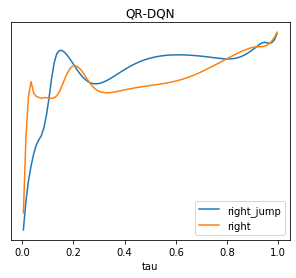

In [338]:
qrdqn = QRDQN().cuda()
# qrdqn.load('data/qcmodel/exqrdqns0_net64up1_iter5_MontezumaRevenge.pkl')
qrdqn.load('data/model/exqrdqn_100_net_MontezumaRevenge.pkl')
b_s,b_a = b_s.cuda(),b_a.cuda()
action_list = ['stop','jump','up','down','right','left','right_jump']
tbq_eval5 = qrdqn(b_s) # (m, N_ACTIONS, N_QUANT)
qq = tbq_eval5.cpu().detach().numpy()
tbq_eval5 = tbq_eval5.index_select(1,torch.LongTensor([0,1,2,5,6,7,11]).cuda())
median = torch.median(tbq_eval5, dim=-1).values.unsqueeze(-1).expand(tbq_eval5.shape)

q = tbq_eval5.mean(dim=2)
bonus_c = 50 * np.sqrt(np.log(tbqrdqn.memory_counter) / tbqrdqn.memory_counter)
var_plus = torch.sqrt(torch.sum(torch.pow((torch.where(tbq_eval5 - median > 0, tbq_eval5, median) - median), 2), dim=-1)/(2*100))
action_value = q + bonus_c * var_plus
best_actions = action_value.argmax(dim=1).detach().cpu().numpy()[0]
print('exploration_action:{}'.format(action_list[best_actions]))

action = int(torch.argmax(q, dim=1).detach().cpu().numpy())
print('exploit_action:{}'.format(action_list[action]))




#0-不动，1跳,2上，3右走，4左走，5下，6右走，7左走，8右走，9左走，10跳（上绳子），11右跳
#12左走，13下，14右走，15左走，16右走
import matplotlib.pyplot as plt
# plt.plot(QUANTS_TARGET,qq[0][0,:],label='stop')#停
# plt.plot(QUANTS_TARGET,qq[0][1,:],label='jump')#跳
# plt.plot(QUANTS_TARGET,qq[0][2,:],label='up')#上
# plt.plot(QUANTS_TARGET,qq[0][3,:],label='action-4')
# plt.plot(QUANTS_TARGET,qq[0][4,:],label='action-5')
# plt.plot(QUANTS_TARGET,qq[0][5,:],label='down')#下
plt.plot(QUANTS_TARGET,qq[0][6,:],label='right_jump')#右
# plt.plot(QUANTS_TARGET,qq[0][7,:],label='left')#左
# plt.plot(QUANTS_TARGET,qq[0][8,:],label='action-9')
# plt.plot(QUANTS_TARGET,qq[0][9,:],label='action-10')
# plt.plot(QUANTS_TARGET,qq[0][10,:],label='action-11')
plt.plot(QUANTS_TARGET,qq[0][11,:],label='right')#右跳
# plt.plot(QUANTS_TARGET,qq[0][12,:],label='action-13')
# plt.plot(QUANTS_TARGET,qq[0][13,:],label='action-14')
# plt.plot(QUANTS_TARGET,qq[0][14,:],label='action-15')
# plt.plot(QUANTS_TARGET,qq[0][15,:],label='action-16')
# plt.plot(QUANTS_TARGET,qq[0][16,:],label='action-17')
# plt.plot(QUANTS_TARGET,qq[0][17,:],label='action-18')
plt.title('QR-DQN'.format(env_name))
plt.xlabel('tau')
# plt.ylabel('Value')
plt.yticks([])
plt.legend()
plt.show()

tensor([1.9434e-07, 1.8999e-07, 1.9750e-07, 1.4924e-07, 1.4708e-07, 1.8267e-07,
        1.8957e-07, 1.9133e-07, 1.8044e-07, 1.9270e-07, 1.7955e-07, 1.8233e-07,
        1.5979e-07, 1.6093e-07, 1.9018e-07, 1.9570e-07, 2.1239e-07, 1.5843e-07],
       device='cuda:0', grad_fn=<SelectBackward>)
[1.826730e-07 1.895704e-07] [2.3620501e-09 2.5428628e-09]
[1.895704e-07 1.826730e-07]


Text(0.5, 1.0, 'Q-value v.s bonus with crossing')

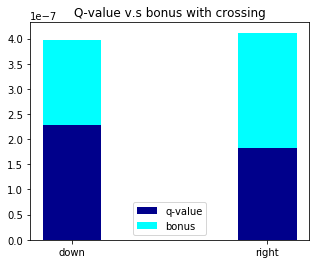

In [250]:
qrdqn = QRDQN().cuda()
# qrdqn.load('data/qcmodel/exqrdqns0_net64up1_iter5_MontezumaRevenge.pkl')
qrdqn.load('data/model/exqrdqn_100_net_MontezumaRevenge.pkl')
b_s,b_a = b_s.cuda(),b_a.cuda()
action_list = ['stop','jump','up','down','right','left','right_jump']
tbq_eval5 = qrdqn(b_s) # (m, N_ACTIONS, N_QUANT)
qq = tbq_eval5.cpu().detach().numpy()
# tbq_eval5 = tbq_eval5.index_select(1,torch.LongTensor([0,1,2,5,6,7,11]).cuda())
median = torch.median(tbq_eval5, dim=-1).values.unsqueeze(-1).expand(tbq_eval5.shape)

q = tbq_eval5.mean(dim=2)
print(q[0])
bonus_c = 50 * np.sqrt(np.log(tbqrdqn.memory_counter) / tbqrdqn.memory_counter)
var_plus = torch.sqrt(torch.sum(torch.pow((torch.where(tbq_eval5 - median > 0, tbq_eval5, median) - median), 2), dim=-1)/(2*100))
action_value = q + bonus_c * var_plus
q_val = q.index_select(1,torch.LongTensor([5,6]).cuda()).detach().cpu().numpy()[0]
b = (bonus_c * var_plus).index_select(1,torch.LongTensor([5,6]).cuda()).detach().cpu().numpy()[0]
# best_actions = action_value.argmax(dim=1).detach().cpu().numpy()[0]
print(q_val,b)
print(q_val[::-1])
q_val = q_val[::-1]
b[0] = b[0]*0.8
q_val[0] =q_val[0]*1.2
ind = ['down','right']
width = 0.3
params = {
    'figure.figsize': '5, 4'
}
plt.rcParams.update(params)
plt.bar(ind, q_val, width, color='#00008B',label='q-value')#, yerr=menStd)
plt.bar(ind, b*90, width, bottom=q_val,color='#00FFFF',label='bonus')
# plt.ylim(min(q_val))
plt.legend()
plt.title('Q-value v.s bonus with crossing'.format(env_name))

tensor([1.9434e-07, 1.8999e-07, 1.9750e-07, 1.4924e-07, 1.4708e-07, 1.8267e-07,
        1.8957e-07, 1.9133e-07, 1.8044e-07, 1.9270e-07, 1.7955e-07, 1.8233e-07,
        1.5979e-07, 1.6093e-07, 1.9018e-07, 1.9570e-07, 2.1239e-07, 1.5843e-07],
       device='cuda:0', grad_fn=<SelectBackward>)
[1.8232545e-07 1.8957040e-07] [7.4984028e-09 2.5428628e-09]
[1.8957040e-07 1.8232545e-07]


Text(0.5, 1.0, 'Q-value v.s Bonus with crossing')

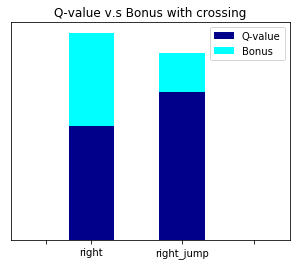

In [330]:
qrdqn = QRDQN().cuda()
# qrdqn.load('data/qcmodel/exqrdqns0_net64up1_iter5_MontezumaRevenge.pkl')
qrdqn.load('data/model/exqrdqn_100_net_MontezumaRevenge.pkl')
b_s,b_a = b_s.cuda(),b_a.cuda()
action_list = ['stop','jump','up','down','right','left','right_jump']
tbq_eval5 = qrdqn(b_s) # (m, N_ACTIONS, N_QUANT)
qq = tbq_eval5.cpu().detach().numpy()
# tbq_eval5 = tbq_eval5.index_select(1,torch.LongTensor([0,1,2,5,6,7,11]).cuda())
median = torch.median(tbq_eval5, dim=-1).values.unsqueeze(-1).expand(tbq_eval5.shape)

q = tbq_eval5.mean(dim=2)
print(q[0])
bonus_c = 50 * np.sqrt(np.log(tbqrdqn.memory_counter) / tbqrdqn.memory_counter)
var_plus = torch.sqrt(torch.sum(torch.pow((torch.where(tbq_eval5 - median > 0, tbq_eval5, median) - median), 2), dim=-1)/(2*100))
action_value = q + bonus_c * var_plus
q_val = q.index_select(1,torch.LongTensor([11,6]).cuda()).detach().cpu().numpy()[0]
b = (bonus_c * var_plus).index_select(1,torch.LongTensor([11,6]).cuda()).detach().cpu().numpy()[0]
# best_actions = action_value.argmax(dim=1).detach().cpu().numpy()[0]
print(q_val,b)
print(q_val[::-1])
ind = [' ','right','right_jump',' ']
# q_val = q_val[::-1]
b[0] = b[0]*0.8
q_val[0] =q_val[0]*0.8
x_pos = np.array([0,0.5,1.5,2.3])
width = 0.5
q_val = np.concatenate(([0],q_val,[0]))
b = np.concatenate(([0],b,[0]))
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax.bar(x_pos, q_val,width,color='#00008B',align='center',label='Q-value')
ax.bar(x_pos, b*20,width,bottom = q_val,color='#00FFFF',align='center',label='Bonus')
ax.set_xticks(x_pos)
ax.set_xticklabels(ind)
ax.set_yticks([])


# ind = ['right','right_jump']
# idc = (np.arange(2)+1)*0.5
# width = 0.3
# params = {
#     'figure.figsize': '5, 4'
# }
# plt.rcParams.update(params)
# # plt.bar(' ', 0, 0.01, color='#00008B')#, ye



# plt.bar(idc, q_val, width, align='center',color='#00008B',label='Q-value')#, yerr=menStd)
# plt.bar(idc, b*20, width, align='center',bottom=q_val,color='#00FFFF',label='Bonus')
# # plt.ylim(min(q_val))
# # plt.bar(' ', 0, 0.01, color='#00008B')#, ye
# # plt.set_xticks(ind[:-1])
# plt.yticks([])
# plt.xticks(ind)
plt.legend()
plt.title('Q-value v.s Bonus with crossing'.format(env_name))

In [319]:
a = list(q_val).insert(0,0)
print(a)

None


tensor([0], device='cuda:0')
tensor([3], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')


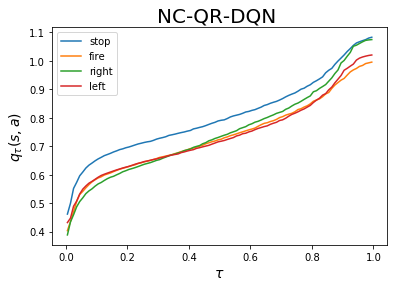

In [11]:

if USE_GPU:
    b_s, b_a,b_s_ = b_s.cuda(), b_a.cuda(), b_s_.cuda()
qqq = []
for itera in [1,5,10,20,40]:    

    tbqrdqn.load_model('data/qcmodel/tbqrdqns0_2net100up1_iter{}_{}.pkl'.format(itera,env_name))

    tbq_eval = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
    
    qq = tbq_eval.cpu().detach().numpy()
    qqq.append(qq)
    q = tbq_eval.mean(dim=2)
    action = torch.argmax(q, dim=1).detach().cuda()
    print(action)
    mb_size = tbq_eval.size(0)
    tbq_eval = torch.stack([tbq_eval[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
    tbqrdqn_eval = tbq_eval.cpu().detach().numpy()
# print(tbqrdqn_eval)

# itera = 5
# tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

# tbq_eval5 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
# qq5 = tbq_eval5.cpu().detach().numpy()
# q = tbq_eval5.mean(dim=2)
# action = torch.argmax(q, dim=1).detach().cuda()
# print(action)
# mb_size = tbq_eval5.size(0)
# tbq_eval5 = torch.stack([tbq_eval5[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
# tbqrdqn_eval5 = tbq_eval5.cpu().detach().numpy()

# itera = 10
# tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

# tbq_eval10 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
# qq10 = tbq_eval10.cpu().detach().numpy()
# q = tbq_eval10.mean(dim=2)
# action = torch.argmax(q, dim=1).detach().cuda()
# print(action)
# mb_size = tbq_eval10.size(0)
# tbq_eval10 = torch.stack([tbq_eval10[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
# tbqrdqn_eval10 = tbq_eval5.cpu().detach().numpy()

# # tbqrdqn.load_model('data/model/extbqrdqn_100_net_{}.pkl'.format(env_name))
# itera = 20
# tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

# tbq_eval20 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
# qq20 = tbq_eval20.cpu().detach().numpy()
# q = tbq_eval20.mean(dim=2)
# action = torch.argmax(q, dim=1).detach().cuda()
# print(action)
# mb_size = tbq_eval20.size(0)
# tbq_eval20 = torch.stack([tbq_eval20[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
# tbqrdqn_eval20 = tbq_eval20.cpu().detach().numpy()

# itera = 40
# tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

# tbq_eval20 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
# qq20 = tbq_eval20.cpu().detach().numpy()
# q = tbq_eval20.mean(dim=2)
# action = torch.argmax(q, dim=1).detach().cuda()
# print(action)
# mb_size = tbq_eval20.size(0)
# tbq_eval20 = torch.stack([tbq_eval20[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
# tbqrdqn_eval20 = tbq_eval20.cpu().detach().numpy()

k=0
qq = qqq[k]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.figure(1)
plt.plot(QUANTS_TARGET,qq[0][0,:],label='stop')
plt.plot(QUANTS_TARGET,qq[0][1,:],label='fire')
plt.plot(QUANTS_TARGET,qq[0][2,:],label='right')
plt.plot(QUANTS_TARGET,qq[0][3,:],label='left')
# plt.plot(QUANTS_TARGET,qrdqn_eval[10],label='tbqrdqn_it1')
# plt.plot(QUANTS_TARGET,tbqrdqn_eval[0],label='tbqrdqn-iter1')
# plt.plot(QUANTS_TARGET,tbqrdqn_eval5[0],label='tbqrdqn-iter5')
# plt.plot(QUANTS_TARGET,tbqrdqn_eval20[0],label='tbqrdqn-iter20')
# plt.plot(fqf_tau_hats[10,:],fqf_eval[10,:],label='fqf')
# plt.plot(tbfqf_tau_hats[10,:],tbfqf_eval[10,:],label='tbfqf')
font = {
         'size': 14,
         }
plt.title('NC-QR-DQN '.format(env_name),fontsize =20)
# ax.set_xlabel('temp',fontsize=18,labelpad = 0)
plt.xlabel(r'$\tau$',font)
plt.ylabel(r'$q_{\tau}(s,a)$',font)
plt.legend()
plt.show()

# fig.savefig('../quantile_curve/ncqc.eps',dpi=600,format='eps')

([], <a list of 0 Text yticklabel objects>)

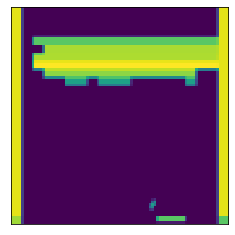

In [19]:

b_s, b_a, b_r,b_s_, b_d = tbqrdqn.replay_buffer._storage[1+725*16]
# b_s, b_a, b_r,b_s_, b_d = self.replay_buffer.sample(BATCH_SIZE)
b_s = torch.FloatTensor(b_s).unsqueeze(0)
b_a = torch.LongTensor(b_a).unsqueeze(0)
# b_r = torch.FloatTensor(b_r).unsqueeze(0)
b_s_ = torch.FloatTensor(b_s_).unsqueeze(0)
# b_d = torch.FloatTensor(b_d).unsqueeze(0)
image = b_s.detach().cpu().numpy()
fig,ax = plt.subplots()
plt.figure(1)
plt.imshow(image[0][0].transpose())
plt.xticks([])
plt.yticks([])
# fig.savefig('../quantile_curve/state.eps',dpi=600,format='eps')

tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
[array([0]), array([0]), array([0]), array([0]), array([1])]
[array([0]), array([1]), array([0]), array([1]), array([1])]
(1, 2, 100)
(1, 2, 100)
(1, 2, 100)
(1, 2, 100)
(1, 2, 100)


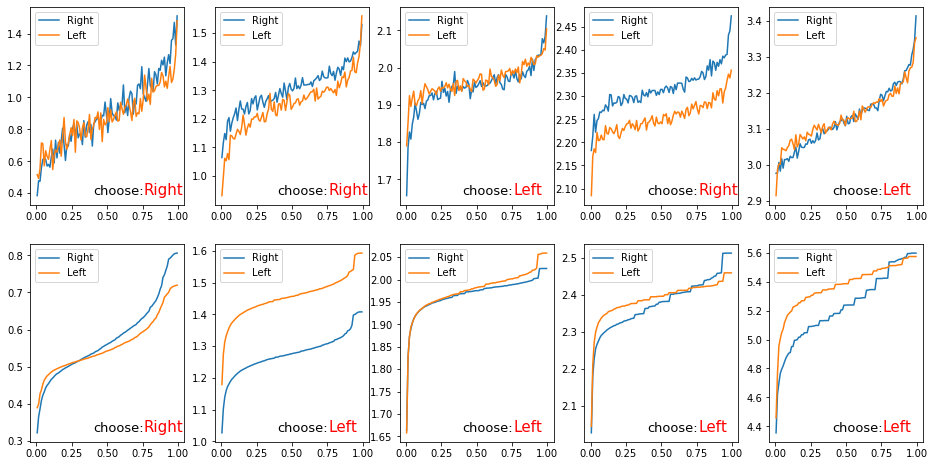

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [84]:
if USE_GPU:
    b_s, b_a,b_s_ = b_s.cuda(), b_a.cuda(), b_s_.cuda()
tbqqq = []
tba = []

for itera in [1,5,10,20,40]:    

    tbqrdqn.load_model('data/qcmodel/tbqrdqns0_2net100up1_iter{}_{}.pkl'.format(itera,env_name))

    tbq_eval = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
    tbq_eval = tbq_eval.index_select(1, torch.LongTensor([2,3]).cuda())
    qq = tbq_eval.cpu().detach().numpy()
    tbqqq.append(qq)
    q = tbq_eval.mean(dim=2)
    action = torch.argmax(q, dim=1).detach().cuda()
    print(action)
    tba.append(action.detach().cpu().numpy())
    mb_size = tbq_eval.size(0)
    tbq_eval = torch.stack([tbq_eval[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
    tbqrdqn_eval = tbq_eval.cpu().detach().numpy()
    
qrdqn = QRDQN()
qrqqq = []
qra = []
b_s,b_a = b_s.cpu(),b_a.cpu()
for itera in [1,5,10,20,40]:
    
    qrdqn.load('data/qcmodel/qrdqns0_2net100up1_iter{}_{}.pkl'.format(itera,env_name))

    

    q_eval = qrdqn(b_s)
    q_eval = q_eval.index_select(1, torch.LongTensor([2,3]))
    qq1 = q_eval.detach().cpu().numpy()
    qrqqq.append(qq1)
    q = q_eval.mean(dim=2)
    action = torch.argmax(q, dim=1).detach().cpu()
    qra.append(action.detach().cpu().numpy())
    print(action)
    mb_size = q_eval.size(0)

    q_eval = torch.stack([q_eval[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)

    qrdqn_eval = q_eval.cpu().detach().numpy()



import matplotlib.pyplot as plt
al = ['Right','Left']
fig = plt.figure(figsize=(16, 8))
# x = np.arange(0,qr[0].shape[1])/qr[0].shape[1]*40
print(qra)
print(tba)
qra[2] = np.array([1])
tba[2] = np.array([1])
for i in range(5):
    if i ==2:
        order = [1,0]
    else:
        order =[0,1]
    ax = fig.add_subplot(2, 5, i+1)
    qq = qrqqq[i]
    print(qq.shape)
    # ax.plot(QUANTS_TARGET,qq[0][0,:],label='stop')
    # ax.plot(QUANTS_TARGET,qq[0][1,:],label='fire')
    ax.plot(QUANTS_TARGET,qq[0][order[0],:],label='Right')
    ax.plot(QUANTS_TARGET,qq[0][order[1],:],label='Left')
#     ax.set_title(al[qra[i][0]])
    tick = ax.get_ybound()
    rang = tick[-1]-tick[0]
    ax.text(0.4, tick[0]+0.05*rang, r'choose:'.format(al[qra[i][0]]),fontsize=13)
    ax.text(0.76, tick[0]+0.05*rang, r'{}'.format(al[qra[i][0]]),fontsize=15,color='red')
    ax.legend()


    ax = fig.add_subplot(2, 5, 5+i+1)
    qq = tbqqq[i]

    ax.plot(QUANTS_TARGET,qq[0][order[0],:],label='Right')
    ax.plot(QUANTS_TARGET,qq[0][order[1],:],label='Left') 
#     ax.set_title(game_list[i])
#     ax.set_title(al[tba[i][0]])
    tick = ax.get_ybound()
    rang = tick[-1]-tick[0]
    ax.text(0.4, tick[0]+0.05*rang, r'choose:'.format(al[tba[i][0]]),fontsize=13)
    ax.text(0.76, tick[0]+0.05*rang, r'{}'.format(al[tba[i][0]]),fontsize=15,color='red')
#     ax.set_xlabel( r'iteration:{}'.format([1,5,10,20,40][i]),fontsize=15)
    ax.legend()


font = {
         'size': 14,
         }
# plt.title('Crossing Fading '.format(env_name),fontsize =20)
# ax.set_xlabel('temp',fontsize=18,labelpad = 0)
# plt.xlabel(r'$\tau$',font)
# plt.ylabel(r'$\theta_{\tau}(s,a)$',font)
plt.legend()
plt.show()

fig.savefig('../quantile_curve/actionsx.eps',dpi=600,format='eps')

In [33]:
if USE_GPU:
    b_s, b_a,b_s_ = b_s.cuda(), b_a.cuda(), b_s_.cuda()
tb_eval = tbqrdqn.pred_net(b_s).squeeze(0)
select = tb_eval.index_select(0, torch.LongTensor([2,3]).cuda())
print(tb_eval.shape)
print(select.shape)

torch.Size([4, 100])
torch.Size([2, 100])


tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([3], device='cuda:0')


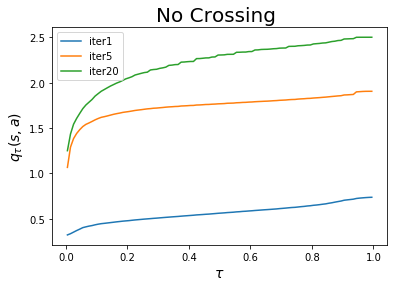

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [43]:
itera=1
tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

if USE_GPU:
    b_s, b_a,b_s_ = b_s.cuda(), b_a.cuda(), b_s_.cuda()
tbq_eval = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
qq1 = tbq_eval.cpu().detach().numpy()
q = tbq_eval.mean(dim=2)
action = torch.argmax(q, dim=1).detach().cuda()
print(action)
mb_size = tbq_eval.size(0)
tbq_eval = torch.stack([tbq_eval[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
tbqrdqn_eval = tbq_eval.cpu().detach().numpy()
# print(tbqrdqn_eval)

itera = 5
tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

tbq_eval5 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
qq5 = tbq_eval5.cpu().detach().numpy()
q = tbq_eval5.mean(dim=2)
action = torch.argmax(q, dim=1).detach().cuda()
print(action)
mb_size = tbq_eval5.size(0)
tbq_eval5 = torch.stack([tbq_eval5[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
tbqrdqn_eval5 = tbq_eval5.cpu().detach().numpy()

# tbqrdqn.load_model('data/model/extbqrdqn_100_net_{}.pkl'.format(env_name))
itera = 20
tbqrdqn.load_model('data/qcmodel/tbqrdqns0_net100up1_iter{}_{}.pkl'.format(itera,env_name))

tbq_eval20 = tbqrdqn.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
qq20 = tbq_eval20.cpu().detach().numpy()
q = tbq_eval20.mean(dim=2)
action = torch.argmax(q, dim=1).detach().cuda()
print(action)
mb_size = tbq_eval20.size(0)
tbq_eval20 = torch.stack([tbq_eval20[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
tbqrdqn_eval20 = tbq_eval20.cpu().detach().numpy()
k=2
qq = [qq1,qq5,qq20][k]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.figure(1)
# plt.plot(QUANTS_TARGET,qq[0][0,:],label='stop')
# plt.plot(QUANTS_TARGET,qq[0][1,:],label='fire')
# plt.plot(QUANTS_TARGET,qq[0][2,:],label='right')
# plt.plot(QUANTS_TARGET,qq[0][3,:],label='left')
# plt.plot(QUANTS_TARGET,qrdqn_eval[10],label='tbqrdqn_it1')
plt.plot(QUANTS_TARGET,qq1[0][3,:],label='iter1')
plt.plot(QUANTS_TARGET,qq5[0][3,:],label='iter5')
plt.plot(QUANTS_TARGET,qq20[0][3,:],label='iter20')
# plt.plot(fqf_tau_hats[10,:],fqf_eval[10,:],label='fqf')
# plt.plot(tbfqf_tau_hats[10,:],tbfqf_eval[10,:],label='tbfqf')
font = {
         'size': 14,
         }
plt.title('No Crossing '.format(env_name),fontsize =20)
# ax.set_xlabel('temp',fontsize=18,labelpad = 0)
plt.xlabel(r'$\tau$',font)
plt.ylabel(r'$q_{\tau}(s,a)$',font)
plt.legend()
plt.show()

fig.savefig('../quantile_curve/nciter.eps',dpi=600,format='eps')

tensor([13], device='cuda:0')
tensor([14], device='cuda:0')
tensor([17], device='cuda:0')


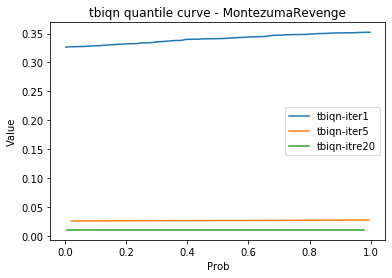

In [96]:
itera = 1
tbiqn.load('data/qcmodel/tbiqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))

# b_s,b_a = b_s.cpu(),b_a.cpu()
b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval,taus = tbiqn(b_s,64)
action = q_eval.mean(dim=2).argmax(dim=1)
print(action)
mb_size = q_eval.size(0)
q_eval = torch.stack([q_eval[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
tbiqn_eval = q_eval.cpu().detach().numpy()
tbiqn_taus = taus.squeeze(1).detach().cpu().numpy()

itera = 5
tbiqn.load('data/qcmodel/tbiqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))
b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval5,taus5 = tbiqn(b_s,64)
action = q_eval5.mean(dim=2).argmax(dim=1)
print(action)
mb_size = q_eval5.size(0)
q_eval5 = torch.stack([q_eval5[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
tbiqn_eval5 = q_eval5.cpu().detach().numpy()
tbiqn_taus5 = taus5.squeeze(1).detach().cpu().numpy()

itera = 20
tbiqn.load('data/qcmodel/tbiqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))
b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval20,taus20 = tbiqn(b_s,64)
action = q_eval20.mean(dim=2).argmax(dim=1)
print(action)
mb_size = q_eval20.size(0)
q_eval20 = torch.stack([q_eval20[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
tbiqn_eval20 = q_eval20.cpu().detach().numpy()
tbiqn_taus20 = taus20.squeeze(1).detach().cpu().numpy()

plt.plot(tbiqn_taus,tbiqn_eval[0,:],label='tbiqn-iter1')
plt.plot(tbiqn_taus5,tbiqn_eval5[0,:],label='tbiqn-iter5')
plt.plot(tbiqn_taus20,tbiqn_eval20[0,:],label='tbiqn-itre20')
# plt.plot(np.sort(iqn_taus),iqn_eval[10,:][np.argsort(iqn_taus)],label='iqn')
plt.title('tbiqn quantile curve - {}'.format(env_name))
plt.xlabel('Prob')
plt.ylabel('Value')
plt.legend()
plt.show()

In [129]:
env_name = 'Jamesbond'
ENV_NAME = '{}NoFrameskip-v4'.format(env_name)
SEED = 0
env = SubprocVecEnv([wrap_cover(ENV_NAME,SEED) for i in range(N_ENVS)])
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape
EPSILON = 0.1
s = np.array(env.reset())
tb = TBQRDQN()
tb.load_model('data/model/extbqrdqn40ms0_100_net_{}.pkl'.format(env_name))
for step in range(1000):
    a = tb.choose_action(s, EPSILON)

    # take action and get next state
    s_, r, done, infos = env.step(a)
    # log arrange

    s_ = np.array(s_)

    # clip rewards for numerical stability
    clip_r = np.sign(r)

    # store the transition
    for i in range(N_ENVS):
        tb.store_transition(s[i], a[i], clip_r[i], s_[i], done[i])
    s = s_

/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <clas

/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <cla

([], <a list of 0 Text yticklabel objects>)

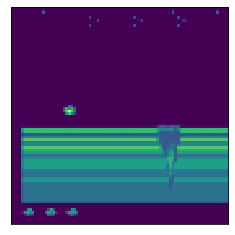

In [130]:
b_s, b_a, b_r,b_s_, b_d = tb.replay_buffer._storage[1+13*16]
# b_s, b_a, b_r,b_s_, b_d = self.replay_buffer.sample(BATCH_SIZE)
b_s = torch.FloatTensor(b_s).unsqueeze(0)
b_a = torch.LongTensor(b_a).unsqueeze(0)
# b_r = torch.FloatTensor(b_r).unsqueeze(0)
b_s_ = torch.FloatTensor(b_s_).unsqueeze(0)
# b_d = torch.FloatTensor(b_d).unsqueeze(0)
image = b_s.detach().cpu().numpy()
plt.imshow(image[0][0].transpose())
plt.xticks([])
plt.yticks([])

In [134]:
tbiqn.load('data/model/tbiqns0_pred_net64_up1_{}.pkl'.format(env_name))
b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
mb_size = x.size(0)
x = tbiqn.feature_extraction(b_s / 255.0) # (m, 7 * 7 * 64)
state_embeddings = x.view(x.size(0), -1) 
weight = tbiqn.weight_net(state_embeddings).view(mb_size, 2, N_ACTIONS)
w = weight[:,0,:].unsqueeze(dim=1)
b = weight[:,1,:].unsqueeze(dim=1)
print(w)
print(b)


tensor([[[0.0480, 0.0505, 0.0551, 0.0466, 0.0543, 0.0410, 0.0465, 0.0565,
          0.0388, 0.0478, 0.0579, 0.0653, 0.0550, 0.0585, 0.0548, 0.0518,
          0.0575, 0.0554]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[0.7327, 0.7306, 0.7303, 0.7350, 0.7302, 0.7350, 0.7323, 0.7315,
          0.7327, 0.7297, 0.7332, 0.7275, 0.7267, 0.7316, 0.7241, 0.7266,
          0.7385, 0.7299]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)


(96,)


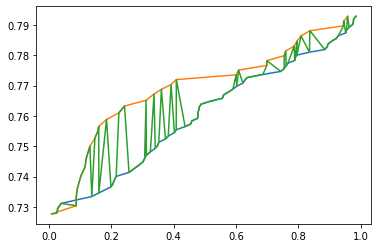

In [152]:
tbiqn.load('data/model/tbiqns0_pred_net64_up1_{}.pkl'.format(env_name))

# b_s,b_a = b_s.cpu(),b_a.cpu()
b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval,taus = tbiqn(b_s,64)
q_eval1,taus1 = tbiqn(b_s,32)
q = torch.cat([q_eval,q_eval1],dim=2).detach().cpu().numpy()[0]

tau = torch.cat([taus,taus1],dim=0).detach().cpu().numpy()
show = q[11,:][np.argsort(tau.squeeze())]
print(tau.squeeze().shape)
# np.argsort(show[])
# print(np.argsort(tau).shape)
plt.plot(np.sort(taus.detach().cpu().numpy().squeeze()),q_eval.detach().cpu().numpy()[0][11,:])
plt.plot(np.sort(taus1.detach().cpu().numpy().squeeze()),q_eval1.detach().cpu().numpy()[0][11,:])
plt.plot(np.sort(tau.squeeze()),show)
# print(q)
# plt.plot(np.sort(tau[:,0]),q[11,:][np.argsort(tau)],label='iqn-itre20')
# np.argsort(tau)


torch.Size([64, 1])

tensor([2], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')


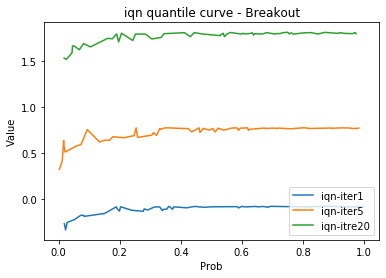

In [230]:
iqn = IQN().cuda()
itera = 1
iqn.load('data/qcmodel/iqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))

# b_s,b_a = b_s.cpu(),b_a.cpu()
b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval,taus = iqn(b_s,64)
action = q_eval.mean(dim=2).argmax(dim=1)
print(action)
mb_size = q_eval.size(0)
q_eval = torch.stack([q_eval[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
iqn_eval = q_eval.cpu().detach().numpy()
iqn_taus = taus.squeeze(1).detach().cpu().numpy()

itera = 5
iqn.load('data/qcmodel/iqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))

b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval5,taus5 = iqn(b_s,64)
action = q_eval5.mean(dim=2).argmax(dim=1)
print(action)
mb_size = q_eval5.size(0)
q_eval5 = torch.stack([q_eval5[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
iqn_eval5 = q_eval5.cpu().detach().numpy()
iqn_taus5 = taus5.squeeze(1).detach().cpu().numpy()

itera = 20
iqn.load('data/qcmodel/iqns0_net64up1_iter{}_{}.pkl'.format(itera,env_name))

b_s, b_a, b_s_= b_s.cuda(), b_a.cuda(), b_s_.cuda()
q_eval20,taus20 = iqn(b_s,64)
action = q_eval20.mean(dim=2).argmax(dim=1)
print(action)
mb_size = q_eval20.size(0)
q_eval20 = torch.stack([q_eval20[i].index_select(0, action[i]) for i in range(mb_size)]).squeeze(1)
iqn_eval20 = q_eval20.cpu().detach().numpy()
iqn_taus20 = taus20.squeeze(1).detach().cpu().numpy()

plt.plot(np.sort(iqn_taus),iqn_eval[0,:][np.argsort(iqn_taus)],label='iqn-iter1')
plt.plot(np.sort(iqn_taus5),iqn_eval5[0,:][np.argsort(iqn_taus5)],label='iqn-iter5')
plt.plot(np.sort(iqn_taus20),iqn_eval20[0,:][np.argsort(iqn_taus20)],label='iqn-itre20')
# plt.plot(np.sort(iqn_taus),iqn_eval[10,:][np.argsort(iqn_taus)],label='iqn')
plt.title('iqn quantile curve - {}'.format(env_name))
plt.xlabel('Prob')
plt.ylabel('Value')
plt.legend()
plt.show()

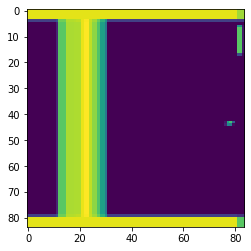

In [83]:

image = b_s.detach().cpu().numpy()
plt.imshow(image[10][3])

In [78]:
self = iqn.cuda()
b_s, b_a, b_r, b_s_, b_d = b_s.cuda(), b_a.cuda(), b_r.cuda(), b_s_.cuda(), b_d.cuda()
q_eval,taus = self(b_s,64)
mb_size = q_eval.size(0)
q_eval = torch.stack([q_eval[i].index_select(0, b_a[i]) for i in range(mb_size)]).squeeze(1)
iqn_eval = q_eval.cpu().detach().numpy()
iqn_taus = taus.squeeze(1).detach().cpu().numpy()

# # plt.plot(tbiqn_taus,tbiqn_eval[10,:],label='tbiqn')
# plt.plot(np.sort(iqn_taus),iqn_eval[10,:][np.argsort(iqn_taus)],label='iqn')
print(np.sort(iqn_taus))
print(iqn_eval[0,:])
print(iqn_eval[0,:][np.argsort(iqn_taus)])

[0.8667636  0.8873928  0.8042175  0.6900934  0.73201287 0.28482962
 0.60397243 0.22776967 0.03759575 0.2898413  0.6011226  0.8307019
 0.18694592 0.6463891  0.8538873  0.87853056 0.699839   0.66254765
 0.93965787 0.6316183  0.56005454 0.15985972 0.09603024 0.44279122
 0.24339539 0.6259061  0.22753477 0.38939136 0.09508491 0.98142934
 0.16643119 0.9077576  0.589022   0.61769927 0.24743503 0.32537287
 0.00836611 0.35790282 0.73224807 0.1488437  0.67691636 0.64533424
 0.06791174 0.81415015 0.9479643  0.43342406 0.6171823  0.25663733
 0.8424077  0.63316685 0.0772723  0.51395756 0.57587    0.6058322
 0.31158787 0.65170896 0.7736958  0.7736561  0.671296   0.44224197
 0.5102056  0.7396684  0.21034443 0.98107046]
[0.00836611 0.03759575 0.06791174 0.0772723  0.09508491 0.09603024
 0.1488437  0.15985972 0.16643119 0.18694592 0.21034443 0.22753477
 0.22776967 0.24339539 0.24743503 0.25663733 0.28482962 0.2898413
 0.31158787 0.32537287 0.35790282 0.38939136 0.43342406 0.44224197
 0.44279122 0.51020

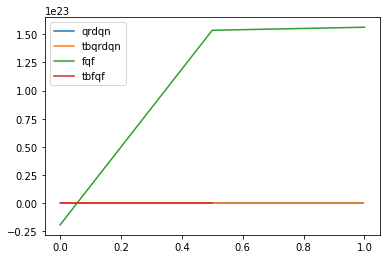

In [377]:
import matplotlib.pyplot as plt
plt.plot(QUANTS_TARGET,qrdqn_eval[10],label='qrdqn')
plt.plot(QUANTS_TARGET,tbqrdqn_eval[10],label='tbqrdqn')
plt.plot(fqf_tau_hats[10,:],fqf_eval[10,:],label='fqf')
plt.plot(tbfqf_tau_hats[10,:],tbfqf_eval[10,:],label='tbfqf')
# plt.plot(tbiqn_taus,tbiqn_eval[10,:],label='tbiqn')
# plt.plot(np.sort(iqn_taus),iqn_eval[10,:][np.argsort(iqn_taus)],label='iqn')
plt.legend()


In [236]:
tau = torch.sort(torch.rand(10, 1),dim=0)[0]
quants = torch.arange(0, 10, 1.0)
cos_trans = torch.cos(quants * tau * 3.141592).unsqueeze(2)

rand_feat = F.relu(phi(cos_trans).mean(dim=1) + phi_bias.unsqueeze(0)).unsqueeze(0) 
x = torch.arange(0,160,1.0).view(32,1,5)
print(x)
print(rand_feat)

print(tau)
print(cos_trans)
(x*rand_feat).shape


tensor([[[  0.,   1.,   2.,   3.,   4.]],

        [[  5.,   6.,   7.,   8.,   9.]],

        [[ 10.,  11.,  12.,  13.,  14.]],

        [[ 15.,  16.,  17.,  18.,  19.]],

        [[ 20.,  21.,  22.,  23.,  24.]],

        [[ 25.,  26.,  27.,  28.,  29.]],

        [[ 30.,  31.,  32.,  33.,  34.]],

        [[ 35.,  36.,  37.,  38.,  39.]],

        [[ 40.,  41.,  42.,  43.,  44.]],

        [[ 45.,  46.,  47.,  48.,  49.]],

        [[ 50.,  51.,  52.,  53.,  54.]],

        [[ 55.,  56.,  57.,  58.,  59.]],

        [[ 60.,  61.,  62.,  63.,  64.]],

        [[ 65.,  66.,  67.,  68.,  69.]],

        [[ 70.,  71.,  72.,  73.,  74.]],

        [[ 75.,  76.,  77.,  78.,  79.]],

        [[ 80.,  81.,  82.,  83.,  84.]],

        [[ 85.,  86.,  87.,  88.,  89.]],

        [[ 90.,  91.,  92.,  93.,  94.]],

        [[ 95.,  96.,  97.,  98.,  99.]],

        [[100., 101., 102., 103., 104.]],

        [[105., 106., 107., 108., 109.]],

        [[110., 111., 112., 113., 114.]],

        [[1

torch.Size([32, 10, 5])

In [229]:
phi = nn.Linear(1, 5, bias=False)
phi_bias = nn.Parameter(torch.zeros(5))

In [134]:
print((quants * tau)[0])
print(quants)
print(tau)

tensor([0.0000, 0.0022, 0.0044, 0.0066, 0.0087, 0.0109, 0.0131, 0.0153, 0.0175,
        0.0197, 0.0219, 0.0241, 0.0262, 0.0284, 0.0306, 0.0328, 0.0350, 0.0372,
        0.0394, 0.0415, 0.0437, 0.0459, 0.0481, 0.0503, 0.0525, 0.0547, 0.0569,
        0.0590, 0.0612, 0.0634, 0.0656, 0.0678, 0.0700, 0.0722, 0.0744, 0.0765,
        0.0787, 0.0809, 0.0831, 0.0853, 0.0875, 0.0897, 0.0918, 0.0940, 0.0962,
        0.0984, 0.1006, 0.1028, 0.1050, 0.1072, 0.1093, 0.1115, 0.1137, 0.1159,
        0.1181, 0.1203, 0.1225, 0.1246, 0.1268, 0.1290, 0.1312, 0.1334, 0.1356,
        0.1378, 0.1400, 0.1421, 0.1443, 0.1465, 0.1487, 0.1509, 0.1531, 0.1553,
        0.1575, 0.1596, 0.1618, 0.1640, 0.1662, 0.1684, 0.1706, 0.1728, 0.1749,
        0.1771, 0.1793, 0.1815, 0.1837, 0.1859, 0.1881, 0.1903, 0.1924, 0.1946,
        0.1968, 0.1990, 0.2012, 0.2034, 0.2056, 0.2077, 0.2099, 0.2121, 0.2143,
        0.2165, 0.2187, 0.2209, 0.2231, 0.2252, 0.2274, 0.2296, 0.2318, 0.2340,
        0.2362, 0.2384, 0.2406, 0.2427, 

In [21]:
env= gym.make('BreakoutNoFrameskip-v4')
s = env.reset()

/home/sufedc_nvidia_wangjianing/anaconda3/envs/rl/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
# s = env.reset()
#0-不动，1跳,2上，3右走，4左走，5下，6右走，7左走，8右走，9左走，10跳（上绳子），11右跳
#12左走，13下，14右走，15左走，16右走
for i in range(3):
    s,r,d,_ = env.step(0)
print(r)
plt.imshow(s)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

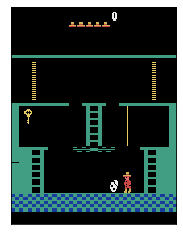

In [1022]:
plt.imshow(s)
plt.xticks([])
plt.yticks([])

#### 

tensor([3., 3.])

In [395]:
2.7*14

37.800000000000004

In [394]:
26*65

1690